# Computing the characteristic impedance of transmission lines using Tidy3D

In this tutorial notebook, we explore the use of Tidy3D to compute the characteristic impedance of transmission lines. The characteristic impedance is a fundamental parameter in the design of transmission lines that affects signal integrity and power distribution. This notebook also serves to introduce [LumpedElements](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/lumped_elements.html) and path integrals, which are components that are used to set up [LumpedPorts](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.LumpedPort.html#tidy3d.plugins.smatrix.LumpedPort) in the [smatrix](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/plugins/smatrix.html) plugin.

The microstrip, a type of transmission line with a conductor strip separated from a ground plane by a dielectric layer, will serve as our example for the study. We will demonstrate how to use the post-processing tools available in the `microwave` plugin to determine the voltage and current distribution along the microstrip both in the time and frequency domains.

The notebook is structured as follows:

1. Set up structures and simulation parameters for a microstrip transmission line.

2. Computation of the voltage and current using path integrals.

3. Calculation of the characteristic impedance.

4. Summary of the three common definitions for the impedance of transmission lines.

5. Example simulation of a microstrip terminated by a matched load.

5. Example of calculating the impedance of a lossy microstrip.

By the end of this notebook, you will have a clear understanding of how to use Tidy3D for simulating and analyzing the characteristic impedance of transmission lines, as well as many of the building blocks used within microwave simulations.

In [1]:
# standard python imports
import matplotlib.pyplot as plt
import numpy as np

# tidy3D imports
import tidy3d as td
import tidy3d.plugins.microwave as microwave
from skrf import Frequency
from skrf.media.mline import MLine
from tidy3d import web
from tidy3d.plugins.dispersion import FastDispersionFitter

# We set the logging level to "ERROR". Otherwise there are numerous warnings due to the proximity of the structure to PML boundaries.
td.config.logging_level = "ERROR"

## Setting up a Microstrip Simulation

The microstrip transmission line that we wish to characterize is presented below. It is characterized by a `width`, `height`, `thickness`, and substrate electric permittivity $\epsilon_r$. For simplicity, conductors are assumed to be perfect electric conductors.

<img src="img/microstrip_geometry.svg" width=800 alt="Schematic of the microstrip">

We can also simplify the simulation by using a PEC boundary condition at the $z$ minimum boundary, which will model the effect of the ground plane.

In [2]:
# Frequency range of interest is from 0.1 GHz to 10 GHz
freq_start = 1e8
freq_stop = 10e9
freq0 = (freq_stop) / 2
fwidth = freq_stop - freq_start
wavelength0 = td.C_0 / freq0
freqs = np.linspace(freq_start, freq_stop, 50)

# Fields should decay rapidly in this notebook, since we are using PMLs.
# Later we will use a matched load that also quickly dissipates power.
run_time = 30 / fwidth

gaussian = td.GaussianPulse.from_frequency_range(freq_start, freq_stop, remove_dc_component=True)
# Default units in Tidy3D are microns
mm = 1e3
# Microstrip parameters (thickness is assumed 0)
length = 40 * mm
width = 3 * mm
height = 1 * mm
thickness = 0.035 * mm

# Size and offset of simulation, so that the microstrip will terminate inside the PML
sim_size = (length + wavelength0 / 2, 3 * width + wavelength0 / 2, height + wavelength0 / 2)
sim_center = (-sim_size[0] / 2 + length / 4, 0, sim_size[2] / 2)

# Conductors are assumed to be perfect electric conductors
# Substrate has permittivity of 4.4
air = td.Medium()
pec = td.PECMedium()
diel = td.Medium(permittivity=4.4)

# Create a structure representing a microstrip along the x axis
strip_center = (0, 0, height + thickness / 2)
strip = td.Structure(
    geometry=td.Box(
        center=strip_center,
        size=[length, width, thickness],
    ),
    medium=pec,
)

# Create a structure representing the substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, 2 * height],
    ),
    medium=diel,
)

# Use a refined mesh near the microstrip, where the fields are mostly contained
dl = thickness
mesh_overrides = [
    td.MeshOverrideStructure(
        geometry=td.Box(
            center=strip_center,
            size=[length + 2 * width, 2 * width, 2 * height],
        ),
        dl=[0.1 * mm, dl, dl],
    ),
]

# Place an excitation at the left (x min) side of the microstrip
uniform_current = td.UniformCurrentSource(
    center=(-length / 2, 0, height / 2),
    size=(0, width, height),
    source_time=gaussian,
    polarization="Ez",
    name="current",
    interpolate=True,
    confine_to_bounds=True,
)

### Initialize monitors and finalize simulation

The voltage and current along the microstrip can be computed by exciting the transmission line using a `UniformCurrentSource`. The source will excite the transmission line mode, which we can then analyze using field monitors in the transverse plane.

In the transverse plane (yz), the fields of the microstrip line are quasi-TEM, which allows for unique definitions of voltage and current [1].

The voltage can be computed by defining a path from the ground to the strip and applying the equation
$$
V_{ab} = V_{a} - V_{b} = - \int^a_b  \mathbf{E} \cdot \mathbf{dl}.
$$

Similarly, to determine the current flowing in the strip along the x axis, we may use Ampère's circuital law
$$
I = \oint_C  \mathbf{H} \cdot \mathbf{dl},
$$
where the path is a closed contour surrounding the strip.

The integration paths are shown in the figure below:

<img src="img/microstrip_paths.svg" width=800 alt="Schematic of the microstrip with path integrals">

In order to perform these computations, we need to set up the `Tidy3D` simulation to record the electric and magnetic fields at these locations. One option is to use a monitor that is large enough to encompass both integration paths. We can also choose two monitors that will be independently used for the voltage and current computations.

In the next cell, monitors for recording the time domain and frequency domain fields are created. An additional monitor is added for plotting the field along the direction of propagation.

In [3]:
# Define all monitors in the simulation

# Monitor for plotting the field along the axis of propagation
propagate_mon = td.FieldMonitor(
    center=[0, 0, height / 2],
    size=[length + 4 * width, 4 * width, 0],
    freqs=[freq0],
    name="propagate",
    colocate=False,
)

# Frequency domain monitor for computing both voltage and current
freq_yz = td.FieldMonitor(
    center=[0, 0, 2 * height],
    size=[0, 4 * width, 4 * height],
    freqs=freqs,
    name="freq_yz",
    colocate=False,
)

# Mode solver monitor, which will be used as an alternate approach for computing impedance.
mode_spec = td.ModeSpec(num_modes=1, target_neff=np.sqrt(4.4))
mode_yz = td.ModeSolverMonitor(
    center=[0, 0, 2 * height],
    size=[0, td.inf, td.inf],
    freqs=freqs,
    name="mode_yz",
    colocate=False,
    mode_spec=mode_spec,
)

# Time monitor for computing voltage
time_voltage_yz = td.FieldTimeMonitor(
    center=[0, 0, height / 2],
    size=[0, 0, height],
    fields=["Ez"],
    interval=40,
    name="time_voltage_yz",
    colocate=False,
)

# Time monitor for computing current
time_current_yz = td.FieldTimeMonitor(
    center=strip_center,
    size=[0, width + 500, thickness + 500],
    fields=["Hy", "Hz"],
    interval=40,
    name="time_current_yz",
    colocate=False,
)

Now, the simulation is set up using the created components. Before running the simulation, we choose to plot the created structure.

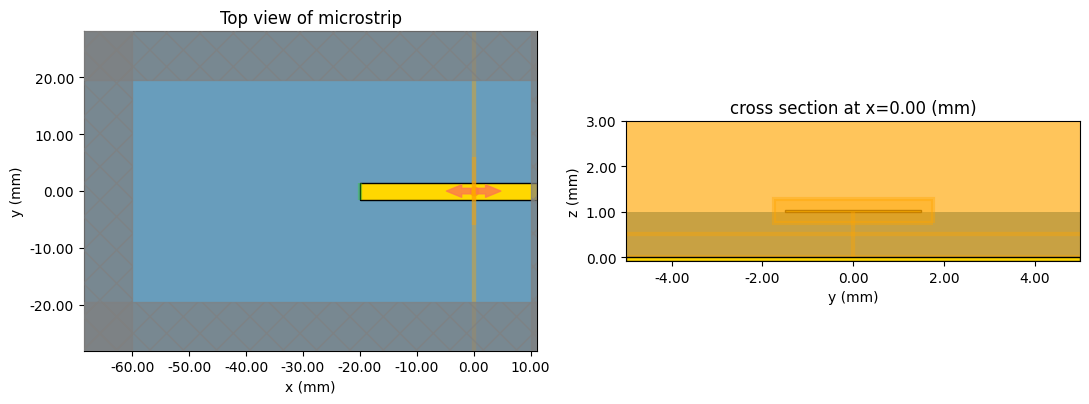

In [4]:
# Using PMLs on every boundary, except for the minus z boundary
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary(plus=td.PML(), minus=td.PECBoundary()),
)

# Simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,
        wavelength=td.C_0 / freq_stop,
        override_structures=mesh_overrides,
        snapping_points=(strip.geometry.bounds[0], strip.geometry.bounds[1]),
    ),
    structures=[substrate, strip],
    sources=[uniform_current],
    monitors=[propagate_mon, freq_yz, mode_yz, time_voltage_yz, time_current_yz],
    run_time=run_time,
    boundary_spec=boundary_spec,
    plot_length_units="mm",
)

# Plot the current simulation setup and scale to millimeters
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))

sim.plot(z=height, ax=ax1)
sim.plot(x=0, ax=ax2, vlim=[0, 3 * mm], hlim=[-5 * mm, 5 * mm])
ax1.set_title("Top view of microstrip")

plt.show()

### Running the simulation

In [5]:
sim_data = web.run(sim, "impedance_calc")

19:32:00 CEST Created task 'impedance_calc' with task_id                        
              'fdve-d18afafc-2247-4696-8b83-cb029c03495a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=624117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=938158;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\taskId]8;;\]8;id=624117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\=]8;;\]8;id=87796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\fdve]8;;\]8;id=624117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\-d18afafc-22]8;;\
              ]8;id=624117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\47-4696-8b83-cb029c03495a']8;;\.

              Task folder: ]8;id=515002;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

19:32:02 CEST Maximum FlexCredit cost: 0.225. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:32:03 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

19:39:02 CEST starting up solver

              running solver

Output()

19:39:16 CEST early shutoff detected at 24%, exiting.

              status = postprocess

Output()

19:39:21 CEST status = success

19:39:23 CEST View simulation result at                                         
              ]8;id=505890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=192864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\taskId]8;;\]8;id=505890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\=]8;;\]8;id=565974;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\fdve]8;;\]8;id=505890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\-d18afafc-22]8;;\
              ]8;id=505890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d18afafc-2247-4696-8b83-cb029c03495a\47-4696-8b83-cb029c03495a']8;;\.

Output()

19:39:27 CEST loading simulation from simulation_data.hdf5

Next, we plot the electric field along the microstrip demonstrating that the transmission line mode has been excited properly. The fields in the transverse plane are presented in the second set of plots. Although the longitudinal field $\mathrm{E}_x$ is not zero, it is two orders of magnitude smaller than the dominant transverse field, which validates the quasi-TEM approximation.

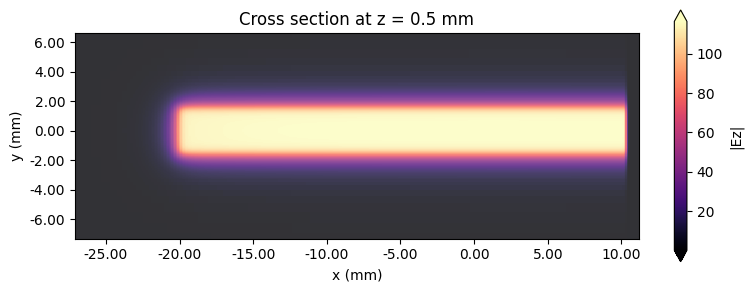

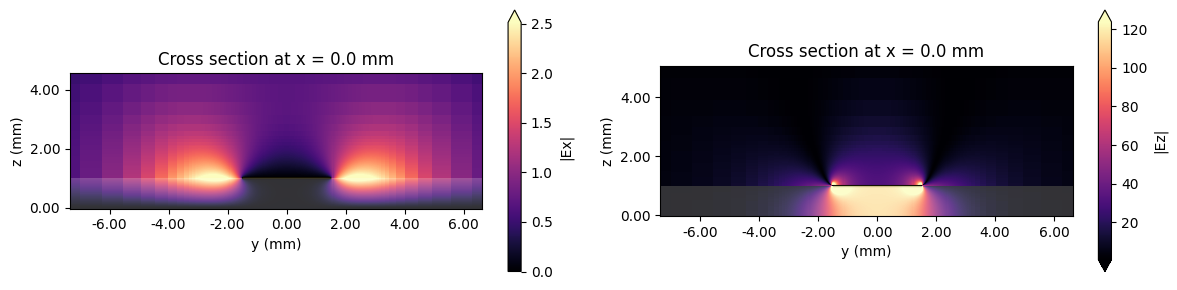

In [6]:
# Plot Ez field in the xy plane
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 3))
sim_data.plot_field(field_monitor_name="propagate", field_name="Ez", val="abs", f=freq0, ax=ax1)
ax1.set_title("Cross section at z = 0.5 mm")

# Plot both the Ex and Ez fields in the xz plane
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 3))
sim_data.plot_field(field_monitor_name="freq_yz", field_name="Ex", val="abs", f=freq0, ax=ax1)
sim_data.plot_field(field_monitor_name="freq_yz", field_name="Ez", val="abs", f=freq0, ax=ax2)
ax1.set_title("Cross section at x = 0.0 mm")
ax2.set_title("Cross section at x = 0.0 mm")
plt.show()

## Time Domain Voltage and Current

Next, we use the [VoltageIntegralAxisAligned](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.VoltageIntegralAxisAligned.html#tidy3d.plugins.microwave.VoltageIntegralAxisAligned) and [CurrentIntegralAxisAligned](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.CurrentIntegralAxisAligned.html) tools from the `microwave` plugin to compute and plot the voltage and current in the time domain.

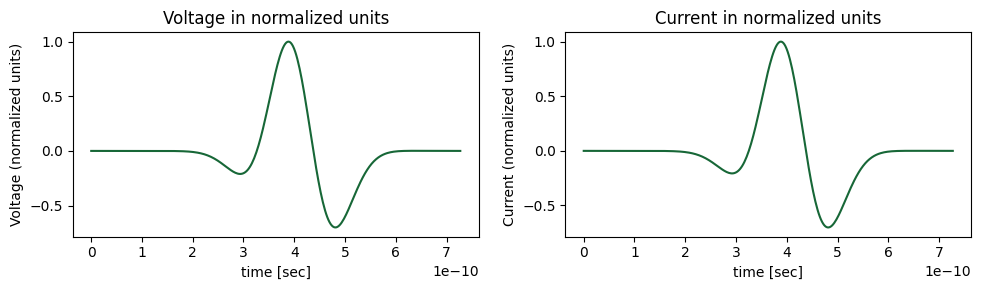

In [7]:
# Retrieve monitor data from the completed simulation
voltage_time_data = sim_data["time_voltage_yz"]
current_time_data = sim_data["time_current_yz"]

# The path for the voltage integral is defined by its center and size along a desired axis.
voltage_path = microwave.VoltageIntegralAxisAligned(
    center=(0, 0, height / 2),
    size=(0, 0, height),
    extrapolate_to_endpoints=True,  # We will explain this in the next step.
    snap_path_to_grid=True,  # If true, the path will be snapped to the Yee grid.
    sign="+",
)
# Compute voltage
voltage_time_domain = voltage_path.compute_voltage(voltage_time_data)

# The path for the current integral is defined by its center and a size.
# The contour will follow the perimeter of the rectangle defined by size.
current_path = microwave.CurrentIntegralAxisAligned(
    center=strip_center,
    size=(0, width + 2 * dl, thickness + 2 * dl),
    snap_contour_to_grid=True,
    sign="+",
)
# Compute current
current_time_domain = current_path.compute_current(current_time_data)

# Plot the time domain voltage and current that is observed at the x=0 position of the microstrip
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
max_voltage = max(abs(voltage_time_domain))
max_current = max(abs(current_time_domain))
(voltage_time_domain / max_voltage).plot(ax=ax1)
ax1.set_title("Voltage in normalized units")
(current_time_domain / max_current).plot(ax=ax2)
ax2.set_title("Current in normalized units")
ax1.set_ylabel("Voltage (normalized units)")
ax2.set_ylabel("Current (normalized units)")
plt.show()

One of the options for the `VoltageIntegralAxisAligned` is whether to `extrapolate_to_endpoints`. The reason for this option is to avoid problems with interpolation of the normal $\mathrm{E}$ component close to metallic interfaces, where the field is discontinuous. As an example, let's first plot the electric field between the ground and microstrip near the peak of the time signal.

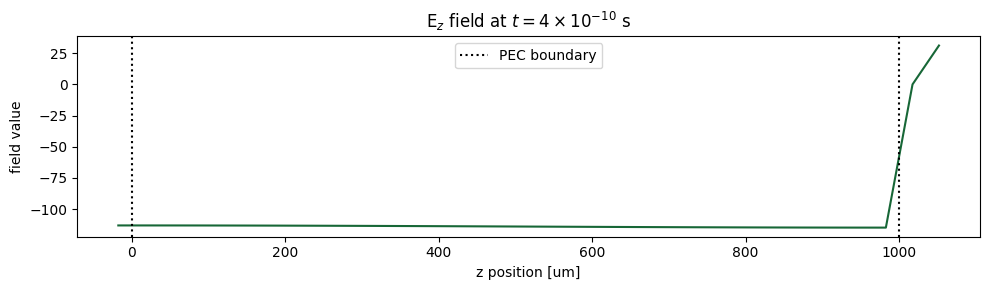

In [8]:
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
Ez_time_slice = voltage_time_data.Ez.sel(t=4e-10, x=0.0, y=0.0, method="nearest")
Ez_time_slice.plot(ax=ax1)
ax1.set_title(r"$\mathrm{E}_z$ field at $t=4 \times 10^{-10}$ s")
# Add the locations of the PEC interfaces
ax1.axvline(x=0, color="k", linestyle=":", label="PEC boundary")
ax1.axvline(x=height, color="k", linestyle=":")
ax1.legend()
plt.show()

The discontinuity at the interface between the substrate and PEC material is located at $z = 1$ mm. An accurate integration of $\mathrm{E}_z$ should extrapolate from $z < 1$ mm, since the field should remain constant up to the PEC interface.

As an example, we will be compute the voltage with `extrapolate_to_endpoints=False` and compute the relative error when compared to the original result. The error is quite small in this case, but can be worse when there are fewer Yee cells along the integration path.

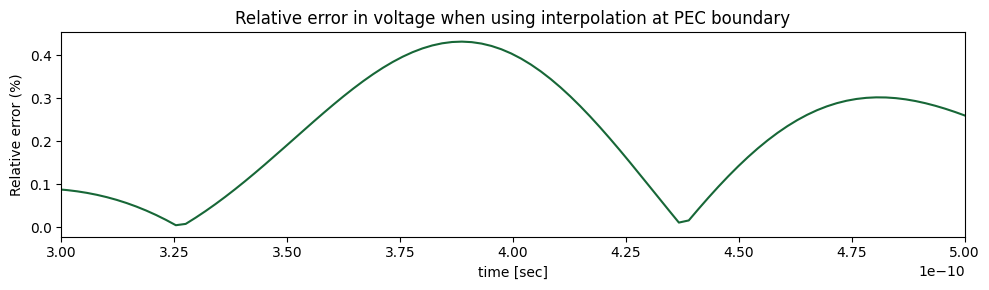

In [9]:
# Define the new voltage path object and compute voltage
voltage_path_no_extrapolate = voltage_path.updated_copy(extrapolate_to_endpoints=False)
voltage_time_domain_no_extrapolate = voltage_path_no_extrapolate.compute_voltage(voltage_time_data)

# Plot the relative error between the original voltage and the new voltage where interpolation is used near PEC interface
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.set(xlim=[3e-10, 5e-10])
voltage_max = max(abs(voltage_time_domain))
error = 100 * (abs(voltage_time_domain - voltage_time_domain_no_extrapolate) / voltage_max)
error.plot(ax=ax1)
ax1.set_title("Relative error in voltage when using interpolation at PEC boundary")
ax1.set_ylabel("Relative error (%)")
plt.show()

## Computing the Characteristic Impedance

Now, we return to the original goal of computing the characteristic impedance of the microstrip. It is more common to compute characteristic impedance in the frequency domain, which we may easily do using the [ImpedanceCalculator](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.ImpedanceCalculator.html) in the [microwave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/plugins/microwave.html) plugin. We simply reuse the definitions of the voltage and current path integrals to create an `ImpedanceCalculator` object. Then, we pass the field data associated with the frequency domain monitor identified by its name "freq_yz". The output of the `compute_impedance` function will be a data array with impedance values as a function of frequency.

Internally, the `ImpedanceCalculator` computes impedance using three possible methods. In this step, we will take the usual approach of computing impedance using $Z_0 = \frac{V}{I}$ [1]. Later, we will demonstrate the two other methods, which are more useful definitions at higher frequencies.

We plot the computed characteristic impedance below as a function of frequency, where we observe that the impedance increases with frequency. The propagation constant and characteristic impedance of microstrip transmission lines are known to depend on frequency, which is due to their quasi-TEM nature [1]. As a sanity check, we include the computed characteristic impedance resulting from a quasi-static model approximation. We also include results from `scikit-rf`, which uses the Hammerstad-Jensen dispersion model to account for how the characteristic impedance changes with frequency. This model captures physical effects like field distribution changes at higher frequencies that a simple quasi-static model cannot represent.

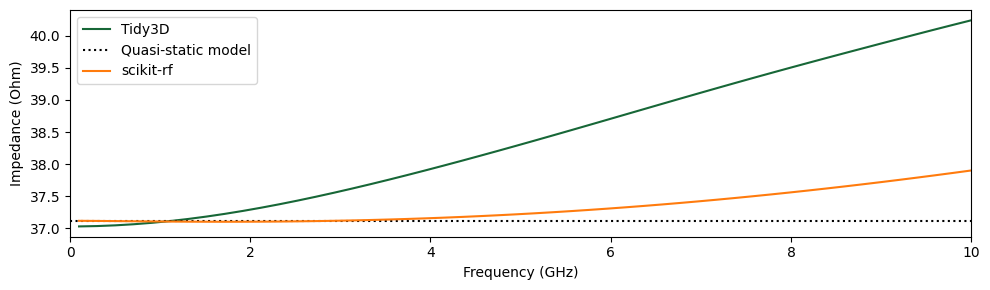

In [10]:
# Pass the voltage and current integral definitions to the impedance calculator.
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=current_path
)
# Compute impedance from frequency domain field data.
impedance = impedance_calculator.compute_impedance(sim_data["freq_yz"])

# Use a quasi-static model of the microstrip to compute an approximate value for the characteristic impedance as a sanity check.
(Zo, _) = microwave.models.microstrip.compute_line_params(4.4, width, height, thickness)

# Also compare to results from scikit-rf
frequency = Frequency.from_f(freqs, unit="Hz")
microstrip = MLine(
    frequency=frequency,
    w=width * 1e-6,
    h=height * 1e-6,
    ep_r=4.4,
    t=thickness * 1e-6,
)
skrf_z0 = np.real(microstrip.z0)

f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.plot(freqs / 1e9, np.real(impedance.values), label="Tidy3D")
ax1.set_ylabel("Impedance (Ohm)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 10)
ax1.axhline(y=Zo, color="k", linestyle=":", label="Quasi-static model")
ax1.plot(freqs / 1e9, skrf_z0, label="scikit-rf")
ax1.legend()
plt.show()

The quasi-static model for impedance is computed following the equations in [2], which is known to be accurate to within 0.2% for microstrips of these dimensions. Tidy3D shows excellent agreement at low frequencies with reference models: within 0.25% of both quasi-static and `scikit-rf` models at 100 MHz. At 10 GHz, the relative error grows to 6% when compared to `scikit-rf`, which is mainly a result of the chosen definition of impedance. Later, we will describe the different definitions and show how to achieve a much closer match to the `scikit-rf` model.

## Defining a Custom Path Integral

Using a path integral that must be defined along an axis, as in `CurrentIntegralAxisAligned`, can be limiting in some circumstances, e.g., computing the current within the inner core of a coaxial cable. In this next part, we demonstrate the usage of `CustomCurrentIntegral2D`, which can accept any user-defined path to perform the integration. We also support `CustomVoltageIntegral2D` which can be used in the same manner.

When using a `CustomCurrentIntegral2D` or `CustomVoltageIntegral2D`, the electromagnetic fields are interpolated from the Yee grid. Therefore, to achieve good accuracy the spacing between vertices on the path should be roughly the same as, or even slightly less than, the grid spacing. On the other hand, choosing too many vertices may lead to a more expensive integration step. Finally, interpolating from fields directly on PEC or other metallic interfaces should be avoided. Hence, below we define a path that includes a small buffer distance from the strip.

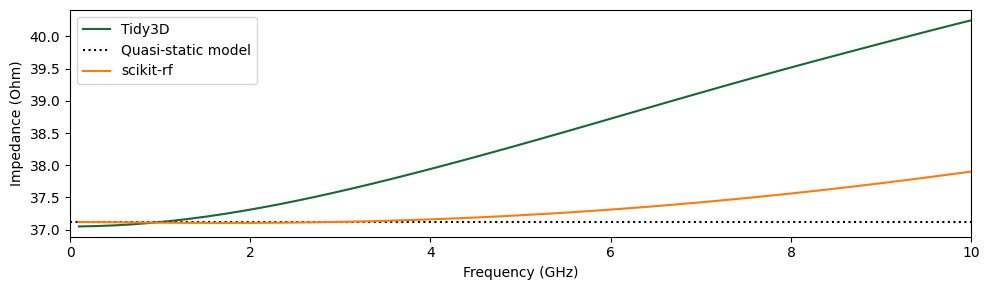

In [11]:
# Setup a path along a rectangular perimeter
Nx = 21
Ny = 11
# Add a buffer distance around the strip, to ensure that we do not interpolate from grid points on the PEC interface
buffer = 200
left = -width / 2 - buffer
right = width / 2 + buffer
bottom = height - buffer
top = height + buffer
y_bottom = np.full((1, Nx), bottom)
y_top = np.full((1, Nx), top)
x_left = np.full((1, Ny), left)
x_right = np.full((1, Ny), right)
x = np.linspace(left, right, Nx)
y = np.linspace(bottom, top, Ny)

# Concatenate the arrays of yz coordinates into a single array
xy_bottom = np.vstack((x, y_bottom))
xy_right = np.vstack((x_right, y))
xy_top = np.vstack((np.flip(x), y_top))
xy_left = np.vstack((x_left, np.flip(y)))
vertices = np.transpose(np.hstack((xy_bottom, xy_right, xy_top, xy_left)))
# Supply the CustomCurrentIntegral2D with the created vertices, along with the normal axis and position of the plane at x=0
custom_path = microwave.CustomCurrentIntegral2D(axis=0, position=0.0, vertices=vertices)
# Setup  the impedance calculator using the previously defined voltage_integral
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=custom_path
)
# Compute the impedance again in the same manner
impedance = impedance_calculator.compute_impedance(sim_data["freq_yz"])

# Plot the results for visual comparison
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.plot(freqs / 1e9, abs(impedance).values, label="Tidy3D")
ax1.set_ylabel("Impedance (Ohm)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 10)
ax1.axhline(y=Zo, color="k", linestyle=":", label="Quasi-static model")
ax1.plot(freqs / 1e9, skrf_z0, label="scikit-rf")
ax1.legend()
plt.show()

The plot generated using the custom-defined path closely matches the plot from earlier, where the `CurrentIntegralAxisAligned` was used.

## Definitions of Characteristic Impedance

In transmission lines supporting quasi-TEM modes, such as microstrips, the electric and magnetic fields do not allow for a unique or consistent definition of impedance [3]. As a result, there are three commonly used definitions:

1. **Voltage–Current Definition:**
   This is the definition used at DC, where impedance is defined as the ratio of voltage (V) to current (I)
   $$
   Z_{VI}=\frac{V}{I}.
   $$

2. **Power–Current Definition:**  
   Here, the impedance is defined using the total power flow (or flux) and the current
   $$ 
   Z_{PI}=\frac{2P}{|I|^2}.
   $$

3. **Power–Voltage Definition:**  
   In this case, impedance is calculated based on the total power flow (flux) and the voltage
   $$
   Z_{PV}=\frac{|V|^2}{2P^*}.
   $$

Of these, the current‐based approach (power–current definition) is generally favored because it exhibits the smallest dependence on frequency, at least for microstrips. Moreover, there is a unique method for defining current, namely by computing the path integral around the conductor. On the other hand, there are many different possible paths one could choose when computing the voltage, which will give slightly different answers since the electromagnetic field is non-conservative, unless the mode is truly a TEM mode.

In the next section, we will demonstrate how the [ImpedanceCalculator](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.ImpedanceCalculator.html) can be used to compute the characteristic impedance using these three different definitions. We also switch to computing the impedance using the electromagnetic mode that have been computed in the [ModeSolverMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSolverMonitor.html#tidy3d.ModeSolverMonitor). Finally, we compare the three different definitions of impedance to the model in `scikit-rf`.

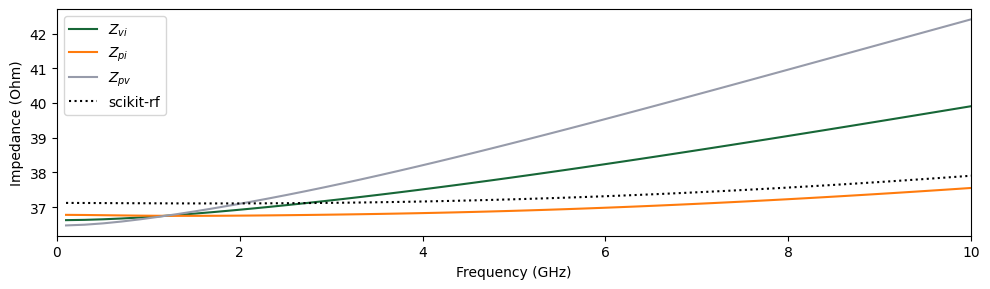

In [12]:
# First we calculate the usual impedance using the same approach as before
# the only difference is now it is computed from mode data.
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=current_path
)
Z_vi = impedance_calculator.compute_impedance(sim_data["mode_yz"])
mode_freqs = Z_vi.f.values
# We select the first mode and convert to a numpy array for plotting
Z_vi = Z_vi.sel(mode_index=0).values

# Next we compute the power-current definition of impedance by simply
# passing "None" in place of the "voltage_path".
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=None, current_integral=current_path
)
Z_pi = impedance_calculator.compute_impedance(sim_data["mode_yz"])
Z_pi = Z_pi.sel(mode_index=0).values
# We compute the power-voltage definition using the same approach.
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=None
)
Z_pv = impedance_calculator.compute_impedance(sim_data["mode_yz"])
Z_pv = Z_pv.sel(mode_index=0).values

# Plot the data associated with the three definitions of impedance
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.plot(mode_freqs / 1e9, np.real(Z_vi), label=r"$Z_{vi}$")
ax1.plot(mode_freqs / 1e9, np.real(Z_pi), label=r"$Z_{pi}$")
ax1.plot(mode_freqs / 1e9, np.real(Z_pv), label=r"$Z_{pv}$")
ax1.plot(freqs / 1e9, skrf_z0, ":k", label="scikit-rf")
ax1.set_ylabel("Impedance (Ohm)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 10)
ax1.legend()
plt.show()

In the above plot, we observe that the three definitions of impedance result in different frequency responses. The `scikit-rf` model is based on the work in [4], which also uses a power-current relationship for defining the impedance, which explains the discrepancies observed previously. When using the power-current relationship, the characteristic impedance calculated by Tidy3D is within 1% of the results produced by `scikit-rf`.

## Adding a Matched Load
Now that we have determined the characteristic impedance of the transmission line, we can perform a final experiment where the microstrip will be terminated by a matched load ($Z_L = Z_0$). If the impedance was computed accurately, the resulting simulation should result in small reflections from the load.

In order to model the load, the `LumpedResistor` element is added to the simulation. We choose a resistance of 38 $\Omega$, which is roughly equal to the characteristic impedance at the central frequency of 5 GHz.

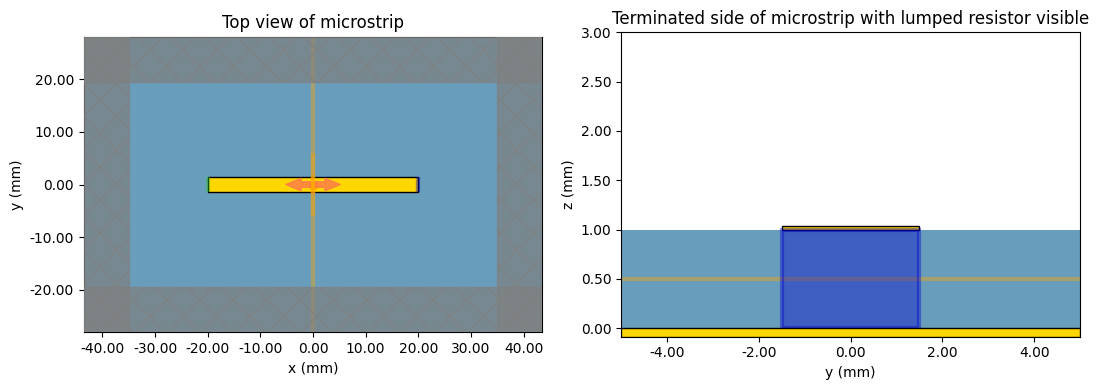

In [13]:
# Shift the center of the simulation domain so that the microstrip does not reach the PML boundary
new_center = list(sim_center)
new_center[0] = 0
# Define a resistor that will be added at the end of the microstrip.
# The lumped resistor is implemented as a 2D conductive sheet, where the conductivity is computed from
# the supplied dimensions, voltage_axis, and the desired resistance.
load = td.LumpedResistor(
    center=(length / 2, 0, height / 2),
    size=(0, width, height),
    num_grid_cells=None,
    voltage_axis=2,
    resistance=38,
    name="load",
)
sim_with_load = sim.updated_copy(center=new_center, lumped_elements=[load])

# Plot the current simulation setup and scale to millimeters
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))
sim_with_load.plot(z=height, ax=ax1)
sim_with_load.plot(x=length / 2, ax=ax2, vlim=[0, 3 * mm], hlim=[-5 * mm, 5 * mm])
ax2.set_aspect("auto")
ax1.set_title("Top view of microstrip")
ax2.set_title("Terminated side of microstrip with lumped resistor visible")
plt.show()

### Running the simulation

In [14]:
sim_data_with_load = web.run(sim_with_load, "impedance_calc_with_load")

19:39:29 CEST Created task 'impedance_calc_with_load' with task_id              
              'fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=409660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=734129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\taskId]8;;\]8;id=409660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\=]8;;\]8;id=662521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\fdve]8;;\]8;id=409660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\-ad1672d7-e9]8;;\
              ]8;id=409660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\2e-4d1a-bf9a-64983b0dd139']8;;\.

              Task folder: ]8;id=989328;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

19:39:31 CEST Maximum FlexCredit cost: 0.279. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:39:32 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

19:42:49 CEST status = preprocess

19:42:53 CEST starting up solver

19:42:54 CEST running solver

Output()

19:43:10 CEST early shutoff detected at 40%, exiting.

19:43:11 CEST status = postprocess

Output()

19:43:15 CEST status = success

19:43:17 CEST View simulation result at                                         
              ]8;id=478808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=499782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\taskId]8;;\]8;id=478808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\=]8;;\]8;id=662489;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\fdve]8;;\]8;id=478808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\-ad1672d7-e9]8;;\
              ]8;id=478808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ad1672d7-e92e-4d1a-bf9a-64983b0dd139\2e-4d1a-bf9a-64983b0dd139']8;;\.

Output()

19:43:22 CEST loading simulation from simulation_data.hdf5

First, we plot the frequency domain fields at the central frequency. Large reflections will manifest as very apparent standing waves along the x axis. In the plot below, we observe only a slight variation of the electric field along x meaning reflections are small. This indicates that the load resistor was closely matched to the characteristic impedance of the transmission line.

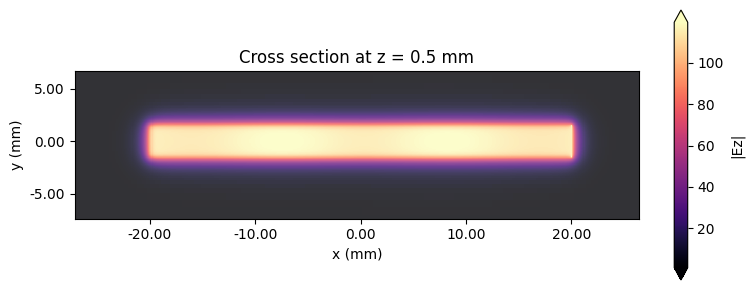

In [15]:
# Plot Ez field in the xy plane
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 3))
sim_data_with_load.plot_field(
    field_monitor_name="propagate", field_name="Ez", val="abs", f=freq0, ax=ax1
)
ax1.set_title("Cross section at z = 0.5 mm")
plt.show()

Next, we inspect the voltage at x = 0.0 in the time domain to get a clearer view of reflections.

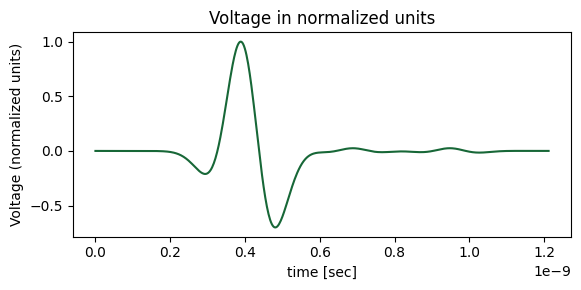

In [16]:
# Retrieve monitor data from the completed simulation
voltage_time_data = sim_data_with_load["time_voltage_yz"]

# The path for the voltage integral is defined by its center and size along a desired axis.
voltage_path = microwave.VoltageIntegralAxisAligned(
    center=(0, 0, height / 2),
    size=(0, 0, height),
    extrapolate_to_endpoints=True,
    snap_path_to_grid=True,  # If true, the path will be snapped to the Yee grid.
    sign="+",
)
# Compute voltage
voltage_time_domain = voltage_path.compute_voltage(voltage_time_data)

# Plot the time domain voltage that is observed at the x = 0 position of the microstrip
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(6, 3))
max_voltage = max(abs(voltage_time_domain))
(voltage_time_domain / max_voltage).plot(ax=ax1)
ax1.set_title("Voltage in normalized units")
ax1.set_ylabel("Voltage (normalized units)")

plt.show()

In the time domain, the reflected voltage waves are barely visible, and as expected their amplitudes are much smaller than the incident wave. Also note that the left-hand side of the microstrip was left open-circuited, which results in large reflections for waves that propagate back to the source position. As a result, multiple reflections are observed in the plot.

## Calculating the Impedance of a Lossy Transmission Line

Finally, we may also analyze lossy transmission, which uses the same steps as shown previously. We simply replace the substrate medium with a lossy dielectric defined by a constant loss tangent. We need to add one additional step, which is to use the `FastDispersionFitter` to create a complex conjugate pole-residue model that approximates the constant loss tangent model.

In [17]:
# Use FastDispersionFitter to create a material with an approximately correct loss tangent for the frequency range.
diel = FastDispersionFitter.constant_loss_tangent_model(
    4.4, 0.025, (freq_start, freq_stop), tolerance_rms=1e-6, number_sampling_frequency=100
)

# Now update the substrate with the lossy dielectric
lossy_substrate = substrate.updated_copy(medium=diel)
sim_with_loss = sim.updated_copy(structures=[lossy_substrate, strip])

Output()

In [18]:
sim_data_with_loss = web.run(sim_with_loss, "impedance_calc")

19:43:25 CEST Created task 'impedance_calc' with task_id                        
              'fdve-fbab71af-da55-4806-b572-0f8a5975982d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=663750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=576698;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\taskId]8;;\]8;id=663750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\=]8;;\]8;id=189503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\fdve]8;;\]8;id=663750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\-fbab71af-da]8;;\
              ]8;id=663750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\55-4806-b572-0f8a5975982d']8;;\.

              Task folder: ]8;id=771675;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

19:43:27 CEST Maximum FlexCredit cost: 0.389. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:43:28 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

19:44:39 CEST starting up solver

              running solver

Output()

19:44:56 CEST early shutoff detected at 24%, exiting.

              status = postprocess

Output()

19:45:00 CEST status = success

19:45:02 CEST View simulation result at                                         
              ]8;id=794706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=988517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\taskId]8;;\]8;id=794706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\=]8;;\]8;id=706327;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\fdve]8;;\]8;id=794706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\-fbab71af-da]8;;\
              ]8;id=794706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbab71af-da55-4806-b572-0f8a5975982d\55-4806-b572-0f8a5975982d']8;;\.

Output()

19:45:07 CEST loading simulation from simulation_data.hdf5

After the simulation is complete, we compare the computed impedance to the model from `scikit-rf`, demonstrating a close agreement.

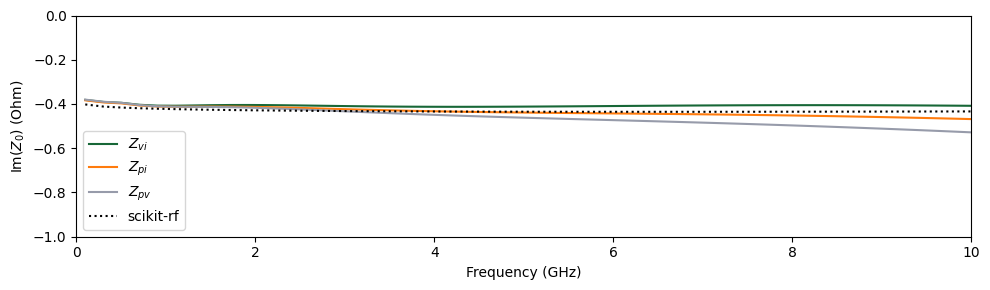

In [19]:
# Also compare to results from scikit-rf
frequency = Frequency.from_f(freqs, unit="Hz")
microstrip = MLine(
    frequency=frequency,
    w=width * 1e-6,
    h=height * 1e-6,
    ep_r=4.4,
    tand=0.025,  # Add an equal loss tangent to the microstrip
    t=thickness * 1e-6,
)
skrf_z0 = microstrip.z0

# First we calculate the usual impedance using the same approach as before
# the only difference is now it is computed from mode data.
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=current_path
)
Z_vi = impedance_calculator.compute_impedance(sim_data_with_loss["mode_yz"])
mode_freqs = Z_vi.f.values
# We select the first mode and convert to a numpy array for plotting
Z_vi = Z_vi.sel(mode_index=0).values

# Next we compute the power-current definition of impedance by simply
# passing "None" in place of the "voltage_path".
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=None, current_integral=current_path
)
Z_pi = impedance_calculator.compute_impedance(sim_data_with_loss["mode_yz"])
Z_pi = Z_pi.sel(mode_index=0).values
# We compute the power-voltage definition using the same approach.
impedance_calculator = microwave.ImpedanceCalculator(
    voltage_integral=voltage_path, current_integral=None
)
Z_pv = impedance_calculator.compute_impedance(sim_data_with_loss["mode_yz"])
Z_pv = Z_pv.sel(mode_index=0).values

# Plot the imaginary part of the data associated with the three definitions of impedance
# With physics convention, the imaginary part of the impedance is negative.
f, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))
ax1.plot(mode_freqs / 1e9, np.imag(Z_vi), label=r"$Z_{vi}$")
ax1.plot(mode_freqs / 1e9, np.imag(Z_pi), label=r"$Z_{pi}$")
ax1.plot(mode_freqs / 1e9, np.imag(Z_pv), label=r"$Z_{pv}$")
ax1.plot(freqs / 1e9, -np.imag(skrf_z0), ":k", label="scikit-rf")
ax1.set_ylabel(r"$\mathrm{Im}(Z_0)$ (Ohm)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 10)
ax1.set_ylim(-1, 0)
ax1.legend()
plt.show()

## References

[1]   David M. Pozar, "Microwave Network Analysis" in Microwave Engineering, 4th ed. 2011, ch. 4.

[2]   E. Hammerstad and O. Jensen, "Accurate Models for Microstrip Computer-Aided Design," 1980 IEEE MTT-S International Microwave Symposium Digest, Washington, DC, USA, 1980, pp. 407-409.

[3]   R. H. Jansen and N. H. L. Koster, "New Aspects Concerning the Definition of Microstrip Characteristic Impedance As a Function of Frequency," 1982 IEEE MTT-S International Microwave Symposium Digest, Dallas, TX, USA, 1982, pp. 305-307.

[4]   R. H. Jansen and M. Kirschning, “Arguments and an accurate Model for the Power-Current Formulation of Microstrip Characteristic Impedance”, Archiv für Elektronik und Übertragungstechnik (AEÜ), vol. 37, pp. 108-112, 1983.

